## Problem 27

We have the following PDE&ICs:

$$\partial_t^2 u = v^2\partial_x^2 u $$
$$u(t,0)=u(t,L)$$
$$u(0,x)=sin\frac{\pi x}{L} +\frac{1}{4}sin\frac{4\pi x}{L}+\frac{1}{16}sin\frac{16\pi x}{L}$$
$$\partial_t u(0,x)=-\frac{\pi v}{L}\left(cos\frac{\pi x}{L} +cos\frac{4\pi x}{L}+cos\frac{16\pi x}{L}\right)$$

Take a scale of $v=L=1$, and compare the following methods for CFL factors of 0.25 and 2:

$\bullet$ FTCS without numerical dissipation

$\bullet$ Lax

$\bullet$ Leapfrog

$\bullet$ Crank-Nicolson

$\bullet$ Method of lines with RK4 with ($\partial_t u,u$) as first order vars

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Initial conds:
# Let us work in the interval [-1,1] by scaling
init_u = lambda x: np.sin(np.pi*x) + np.sin(np.pi*4*x)/4 + np.sin(np.pi*16*x)/16
init_du_dt = lambda x: -np.pi*(np.cos(np.pi*x) + np.cos(np.pi*4*x) + np.cos(np.pi*16*x))
#2nd derivative of init_u, which will be useful in approximating the state of sys at t= +delta_t:
dx2_init_u = lambda x:  -(np.pi**2)*(np.sin(np.pi*x)+4*np.sin(4*np.pi*x)+16*np.sin(16*np.pi*x))
x_pts = 30
x_interval_pts = np.linspace(-1,1,x_pts)
delta_x = 2/x_pts
delta_t = 1/60
step_count = int(1/delta_t)  # t from 0 to 1
t_interval_pts = np.linspace(0,step_count*delta_t,step_count)
deltx2 = delta_t**2/(delta_x**2)
print(f"Δt={delta_t}\nΔx={delta_x}\nΔt/Δx={delta_t/delta_x}")

Δt=0.016666666666666666
Δx=0.06666666666666667
Δt/Δx=0.25


#### FTCS without numerical dissipation

We can discretize u(t,x) as follows, where n stands for the temporal index and j for the spatial index:

$$\frac{u_j^n-2u_j^{n+1}+u_j^{n+2}}{\Delta t^2}=\frac{u_{j+1}^n-2u_j^n+u_{j-1}^n}{\Delta x^2}$$

Then we can find $u_j^{n+2}$ as:

$$u_j^{n+2}=\frac{(\Delta t)^2}{(\Delta x)^2}(u_{j+1}^n-2u_j^n+u_{j-1}^n)-u_j^n+2u_j^{n+1}$$

We also need to bootstrap the iteration by providing a second step on top of u(0,x), which we can do by using a Taylor approximation $u(0,x) + \Delta t\partial_tu(0,x) + \frac{(\Delta t)^2}{2}(\partial_x^2u(0,x))$ as a second step.

In [2]:
def solution_3d_plot(x_interval_pts,t_interval_pts,sln):
    fig = plt.figure()
    ax = plt.axes(projection="3d")
    x, t = np.meshgrid(x_interval_pts, t_interval_pts)
    ax.plot_surface(x, t, np.array(sln))
    ax.set_xlabel('x/L')
    ax.set_ylabel('t')
    ax.set_zlabel('Amp')
    plt.show()

    
def heat_plot(result):
    extent = [-1, 1, t_interval_pts[-1],0]
    plt.xlabel('x/L')
    plt.ylabel('t')
    plt.imshow(result, extent=extent)
    plt.colorbar(label="Amp")

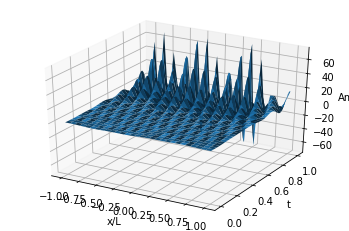

In [3]:
# FTCS without dissipation
ftcs_state = []
ftcs_state.append(init_u(x_interval_pts))  # n=0 Initial positions
ftcs_state.append(ftcs_state[0] + delta_t * init_du_dt(x_interval_pts)\
                  + (delta_t**2)*dx2_init_u(x_interval_pts)/2 ) # n=1
# Now, implementing the iteration:
for i in range(2,step_count):
    tmp = []
    for j in range(x_pts):
        next_j = 2*ftcs_state[i-1][j]-ftcs_state[i-2][j]
        if j==x_pts-1:  # Implementing Periodic BCs
            next_j += deltx2*(ftcs_state[i-2][0]-2*ftcs_state[i-2][j]+ftcs_state[i-2][j-1])
        else:
            next_j += deltx2*(ftcs_state[i-2][j+1]-2*ftcs_state[i-2][j]+ftcs_state[i-2][j-1])
        tmp.append(next_j)
    ftcs_state.append(np.array(tmp))
        
# Plotting:
solution_3d_plot(x_interval_pts,t_interval_pts,ftcs_state)

As expected, the absolute amplitudes grow as time progresses when we use FTCS without dissipation

#### Leapfrog method:

Discretizing as follows:

$$\frac{u_j^{n-1}-2u_j^{n}+u_j^{n+1}}{\Delta t^2}=\frac{u_{j+1}^n-2u_j^n+u_{j-1}^n}{\Delta x^2}$$

Then we can find $u_j^{n+1}$ as:

$$u_j^{n+1}=\frac{(\Delta t)^2}{(\Delta x)^2}(u_{j+1}^n-2u_j^n+u_{j-1}^n)-u_j^{n-1}+2u_j^{n}$$

We can bootstrap in a similar fashion as we did in FTCS


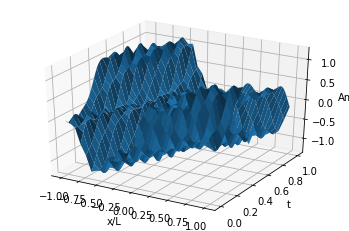

In [4]:
frog_state = []
frog_state.append(init_u(x_interval_pts))  # n=0 Initial positions
frog_state.append(frog_state[0] + delta_t * init_du_dt(x_interval_pts)\
                  + (delta_t**2)*dx2_init_u(x_interval_pts)/2 ) # n=1
# Now, implementing the iteration:
for i in range(2,step_count):
    tmp = []
    for j in range(x_pts):
        next_j = 2*frog_state[i-1][j]-frog_state[i-2][j]
        if j==x_pts-1:  # Implementing Periodic BCs
            next_j += deltx2*(frog_state[i-1][0]-2*frog_state[i-1][j]+frog_state[i-1][j-1])
        else:
            next_j += deltx2*(frog_state[i-1][j+1]-2*frog_state[i-1][j]+frog_state[i-1][j-1])
        tmp.append(next_j)
    frog_state.append(np.array(tmp))
        
# Plotting:
solution_3d_plot(x_interval_pts,t_interval_pts,frog_state)

Now, the increase in abs amplitude seems to be dampened for this time period, and when CFL factor is taken as 0.25, there is no obvious abs amp increase. When the CFL factor is taken as 2, the increase in FTCS gets stronger and the Leapfrog method also yields to abs amp increase, though not as much as FTCS.

#### Lax Method:

We can introduce a dissipatory term to our wave equation and solve accordingly after discretization:

$$\partial_t^2 u=\partial_x^2 u + \frac{(\Delta x)^4}{(\Delta t)^2}\partial_x^4 u$$

Using central finite differencing:

$$\frac{u_j^{n-1}-2u_j^{n}+u_j^{n+1}}{\Delta t^2}=\frac{u_{j+1}^n-2u_j^n+u_{j-1}^n}{\Delta x^2}+\frac{(\Delta x)^4}{(\Delta t)^2}(u_{j+2}^n-4u_{j+1}^n+6u_j^n-4u_{j-1}^n+u_{j-2}^n)$$

Then $u_j^{n+1}$ is:

$$u_j^{n+1}=\frac{(\Delta t)^2}{(\Delta x)^2}(u_{j+1}^n-2u_j^n+u_{j-1}^n)-u_j^{n-1}+2u_j^{n} + (\Delta x)^4(u_{j+2}^n-4u_{j+1}^n+6u_j^n-4u_{j-1}^n+u_{j-2}^n)$$

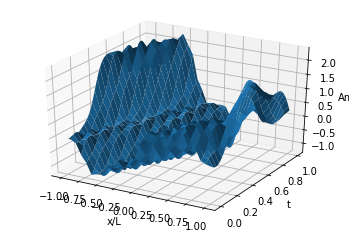

In [5]:
lax_state = []
lax_state.append(init_u(x_interval_pts))  # n=0 Initial positions
lax_state.append(lax_state[0] + delta_t * init_du_dt(x_interval_pts)\
                  + (delta_t**2)*dx2_init_u(x_interval_pts)/2 ) # n=1, not using dissipation at this step
# Implementing the iteration:
delta_x4 = delta_x**4
for i in range(2,step_count):
    tmp = []
    for j in range(x_pts):
        next_j = 2*lax_state[i-1][j]-lax_state[i-2][j]
        if j==x_pts-1:
            next_j += deltx2*(lax_state[i-1][-1]-2*lax_state[i-1][j]+lax_state[i-1][j-1])
            next_j += delta_x4*(lax_state[i-1][1]-4*lax_state[i-1][0]+6*lax_state[i-1][j]\
                               -4*lax_state[i-1][j-1]+lax_state[i-1][j-2])
        elif j==x_pts-2:
            next_j += deltx2*(lax_state[i-1][j+1]-2*lax_state[i-1][j]+lax_state[i-1][j-1])
            next_j += delta_x4*(lax_state[i-1][0]-4*lax_state[i-1][j+1]+6*lax_state[i-1][j]\
                               -4*lax_state[i-1][j-1]+lax_state[i-1][j-2])
        else:
            next_j += deltx2*(lax_state[i-1][j+1]-2*lax_state[i-1][j]+lax_state[i-1][j-1])
            next_j += delta_x4*(lax_state[i-1][j+2]-4*lax_state[i-1][j+1]+6*lax_state[i-1][j]\
                               -4*lax_state[i-1][j-1]+lax_state[i-1][j-2])
        tmp.append(next_j)
    lax_state.append(np.array(tmp))
        
# Plotting:
solution_3d_plot(x_interval_pts,t_interval_pts,lax_state)

$\bullet$ Let us also take a look at the heat plots of the previous three methods.

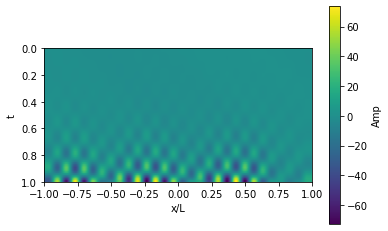

In [6]:
heat_plot(ftcs_state)

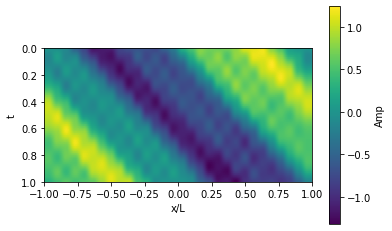

In [7]:
heat_plot(frog_state)

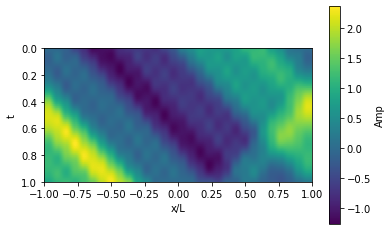

In [8]:
heat_plot(lax_state)